## Buy Now, Pay Later Project
### MAST30034: Applied Data Science 
#### Notebook 2: Preprocessing Data 2: Missing Value and Outliers Detection

In [1]:
# create modeling spark session
from pyspark.sql import SparkSession
import pandas as pd

spark = (
    SparkSession.builder.appName('Project 2 test')
    .config('spark.sql.repl.eagerEval.enabled', True) 
    .config('spark.sql.parquet.cacheMetadata', 'true')
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.executor.memory", "8g")
    .config("spark.driver.memory", "8g")
    .getOrCreate()
)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/09/21 16:20:01 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/09/21 16:20:02 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [2]:
full = spark.read.parquet('../data/curated/full_dataset/')
full


postcode,user_id,merchant_abn,dollar_value,order_datetime,name,business_area,revenue_level,take_rate,consumer_id,state,gender,Median_age_persons,Median_mortgage_repay_monthly,Median_tot_prsnl_inc_weekly,Median_rent_weekly,Median_tot_fam_inc_weekly,Average_num_psns_per_bedroom,Median_tot_hhd_inc_weekly,Average_household_size
3332,14,96161947306,112.67012437787673,2021-08-20,Imperdiet Dictum ...,shoe shops,b,4.52,1343547,VIC,Male,38,1733,797,350,2096,0.8,1955,2.9
3332,14,75900778714,546.6848295784864,2021-08-20,Laoreet Posuere F...,florists supplies...,c,2.61,1343547,VIC,Male,38,1733,797,350,2096,0.8,1955,2.9
3332,14,68216911708,32.90127154333186,2021-08-20,Placerat Eget Ven...,"computers, comput...",c,3.05,1343547,VIC,Male,38,1733,797,350,2096,0.8,1955,2.9
3332,14,20985347699,0.27083188402634917,2021-08-21,Semper Tellus PC,tent and awning s...,a,6.10,1343547,VIC,Male,38,1733,797,350,2096,0.8,1955,2.9
3332,14,45629217853,8.204284579030558,2021-08-14,Lacus Consulting,"gift, card, novel...",a,6.98,1343547,VIC,Male,38,1733,797,350,2096,0.8,1955,2.9
3332,14,92308095254,102.3328793223507,2021-07-15,Non Lorem LLC,"gift, card, novel...",a,6.53,1343547,VIC,Male,38,1733,797,350,2096,0.8,1955,2.9
3332,14,17678252870,36.297748446791886,2021-08-16,Faucibus Morbi Fo...,"watch, clock, and...",c,2.07,1343547,VIC,Male,38,1733,797,350,2096,0.8,1955,2.9
3332,14,64203420245,53.08523476846913,2021-08-16,Pede Nonummy Corp.,tent and awning s...,c,2.86,1343547,VIC,Male,38,1733,797,350,2096,0.8,1955,2.9
3332,14,16570599421,12.142216147150515,2021-08-16,Non Magna Nam PC,digital goods: bo...,a,6.74,1343547,VIC,Male,38,1733,797,350,2096,0.8,1955,2.9
3332,14,50644203172,1501.5614321919952,2021-08-27,Ut LLC,"hobby, toy and ga...",b,4.64,1343547,VIC,Male,38,1733,797,350,2096,0.8,1955,2.9


In [3]:
# check if missing value exists in all columns
# census do not contain all postcodes, there are 
null_count = 0
for col in full.columns:
    null_count += full.filter(full[col].isNull()).count()
    print(full.filter(full[col].isNull()).count())
print("\n", null_count)

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0

 0


There is no missing value in the curated full dataset.

there are 2378048 transactions with their postcode not exist in census data

### Outlier Detection

In [4]:
from pyspark.sql import functions as F
full.groupBy(F.col('merchant_abn')).count().orderBy(F.col('count').asc())

merchant_abn,count
24212300522,1
39150153670,1
51425051982,1
28311306642,1
42461534060,1
10404542215,1
29068447069,1
93267734067,1
62688594508,1
47047735645,1


It is noticed that there exists a range of merchants which only has a single transaction. Such small count of transaction could not provide enough information. So draw boxplot to see the distribution of number of transactions based on merchant.

In [5]:
count_sdf = full.groupBy(F.col('merchant_abn')).count()
# convert to df to draw boxplot
count_df = count_sdf.toPandas()

In [6]:
count = count_df['count']
count

0       11777
1        4312
2        5863
3         243
4         604
        ...  
4021        1
4022        1
4023        2
4024        1
4025        1
Name: count, Length: 4026, dtype: int64

<AxesSubplot:>

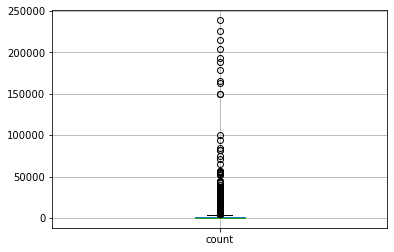

In [7]:
count_df.boxplot(column='count', return_type='axes')

In [8]:
# using IQR to examine the distribution
import numpy as np
sorted(count)
q1, q3= np.percentile(count,[25,75])
iqr = q3 - q1
lower_bound = q1 -(1.5 * iqr) 
upper_bound = q3 +(1.5 * iqr) 
print("mean: ", np.mean(count))
print(q1, q3)
print(upper_bound, lower_bound)

mean:  2790.9709388971683
78.0 1697.0
4125.5 -2350.5


We can see that the distribution of count of transactions is highly left distributed. There are 25% of merchants which has less or equal to 45.0 transactions.   

However, merchants with a very low number of transactions would not be ideal buisness partner with our BNPL company for the following 2 reasons. First, little turnover will result in little total revenue. Secondly, even if the total revenue is high (jewelry company onlys sell one order but brings considerable profit), the BNPL company still has to take the risk of no transaction at all after cooperation. 

Most importantly, such small amount of transactions for merchants could not provide enough information for our model to determine whether these merchants are worth cooperated. 

Therefore, merchants with less than 10 transactions would be selected. And these merchants will then be compared to the merchants which has least total amount...

In [9]:
least_freq_merchants = count_df[count_df['count'] < 10]

In [10]:
least_freq_merchants

,merchant_abn,count
86,69431337574,7
288,39150153670,1
310,13747603419,7
410,29166700531,7
507,27518736748,5
...,...,...
4021,52524795452,1
4022,28311306642,1
4023,24174334793,2
4024,42461534060,1


In [11]:
amount = full.groupBy(F.col('merchant_abn')).sum('dollar_value')
amount_df = amount.toPandas()
amount_df

,merchant_abn,sum(dollar_value)
0,83412691377,4.119111e+05
1,73256306726,1.223133e+06
2,38700038932,7.885045e+06
3,41956465747,5.485230e+04
4,19839532017,9.482800e+04
...,...,...
4021,52524795452,1.286445e+04
4022,28311306642,2.115933e+04
4023,24174334793,1.684496e+04
4024,42461534060,2.260011e+04


<AxesSubplot:>

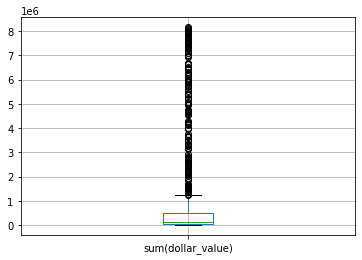

In [12]:
amount_df.boxplot(column='sum(dollar_value)', return_type='axes')

array([[<AxesSubplot:title={'center':'sum(dollar_value)'}>]], dtype=object)

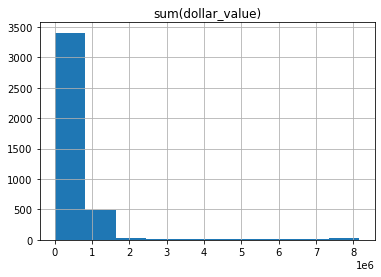

In [13]:
amount_df.hist(column='sum(dollar_value)')

Similiarly, the distribution of total amount of transactions are highly left-skewed.

In [14]:
total_amount = amount_df["sum(dollar_value)"]

In [15]:
# using IQR to examine the distribution
import numpy as np
sorted(total_amount)
q1, q3= np.percentile(total_amount,[25,75])
iqr = q3 - q1
lower_bound = q1 -(1.5 * iqr) 
upper_bound = q3 +(1.5 * iqr) 
print("mean: ", np.mean(total_amount))
print(q1, q3)
print(upper_bound, lower_bound)

mean:  442218.54996027413
30145.197214420205 518845.5494435874
1251896.0777873383 -702905.3311293307


In [16]:
# consider merchants with total value < 10000 as least_amount_merchants
least_amount_merchants = amount_df[amount_df['sum(dollar_value)'] < 50000]

# 这里我改成5w了，之前1w只有两个merchant filter出去

In [17]:
least_amount_merchants

,merchant_abn,sum(dollar_value)
6,92202115241,31983.046434
9,12516851436,27474.244575
12,60654402457,13345.636704
13,34440496342,16365.406022
14,38986645707,35073.485729
...,...,...
4021,52524795452,12864.454745
4022,28311306642,21159.331218
4023,24174334793,16844.963426
4024,42461534060,22600.105673


In [18]:
# combine merchants with both least frequency and least amount
least_merchants = pd.merge(least_freq_merchants, least_amount_merchants)
least_merchants

,merchant_abn,count,sum(dollar_value)
0,69431337574,7,28781.573640
1,39150153670,1,38089.939272
2,13747603419,7,14705.968756
3,29166700531,7,11888.695901
4,27518736748,5,9896.230554
...,...,...,...
159,52524795452,1,12864.454745
160,28311306642,1,21159.331218
161,24174334793,2,16844.963426
162,42461534060,1,22600.105673


There are 123 merchants which have less than 10 number of transactions and their total transaction dollar value is less than 50000. Those merchants has too little frequency of transaction records which could not provide enough information for our model, and has the least potential to be identified as ideal companies. Therefore, they are considerred as outliers and will be removed from the dataset.

In [19]:
removed_merchants = least_merchants["merchant_abn"].to_list()

In [20]:
clean_full = full.filter(~full.merchant_abn.isin(removed_merchants))

### Buisness Area Allocation

In the turnovers dataset, buisness areas are classfied into 13 categories, including ["Mining", "Manufacturing", "Electricity gas water waste service", "Construction", "Wholesale_trade", "Retail_trade", "Accommodation food services", "Transport postal warehousing", "Information media telecommunications", "Professional scientific technical services", "Administrative support services", "Arts recreation services", "Other_services"]

In order to map our full dataset with this turnover dataset, we manually classfies the "business_area" into these 13 categories as follows.

In [21]:
busi_area = clean_full.groupby('business_area').count().sort("business_area").select("business_area").toPandas()['business_area'].to_list()
busi_area


['antique shops - sales, repairs, and restoration services',
 'art dealers and galleries',
 'artist supply and craft shops',
 'bicycle shops - sales and service',
 'books, periodicals, and newspapers',
 'cable, satellite, and other pay television and radio services',
 'computer programming , data processing, and integrated systems design services',
 'computers, computer peripheral equipment, and software',
 'digital goods: books, movies, music',
 'equipment, tool, furniture, and appliance rent al and leasing',
 'florists supplies, nursery stock, and flowers',
 'furniture, home furnishings and equipment shops, and manufacturers, except appliances',
 'gift, card, novelty, and souvenir shops',
 'health and beauty spas',
 'hobby, toy and game shops',
 'jewelry, watch, clock, and silverware shops',
 'lawn and garden supply outlets, including nurseries',
 'motor vehicle supplies and new parts',
 'music shops - musical instruments, pianos, and sheet music',
 'opticians, optical goods, and eye

In [22]:
# the mapping is based on common knowledge and references from industry information published by Australian Government.
#  https://business.gov.au/planning/industry-information
busi_area_type = ["Retail trade", "Arts and recreation services", "Retail trade", "Retail trade", "Retail trade", "Retail trade", "Professional, scientific and technical services", "Retail trade",
"Retail trade", "Retail trade", "Retail trade", "Manufacturing", "Retail trade", "Other services", "Retail trade", "Retail trade", "Retail trade", "Retail trade", 
"Retail trade", "Manufacturing", "Retail trade", "Retail trade", "Information media and telecommunications", "Retail trade", "Other services"]

allocation_df = pd.DataFrame(list(zip(busi_area, busi_area_type)),
               columns =['business_area', 'business_area_type'])
allocation_df

,business_area,business_area_type
0,"antique shops - sales, repairs, and restoratio...",Retail trade
1,art dealers and galleries,Arts and recreation services
2,artist supply and craft shops,Retail trade
3,bicycle shops - sales and service,Retail trade
4,"books, periodicals, and newspapers",Retail trade
5,"cable, satellite, and other pay television and...",Retail trade
6,"computer programming , data processing, and in...","Professional, scientific and technical services"
7,"computers, computer peripheral equipment, and ...",Retail trade
8,"digital goods: books, movies, music",Retail trade
9,"equipment, tool, furniture, and appliance rent...",Retail trade


In [23]:
turnover = pd.read_csv('../data/tables/turnover/Business turnover indicator, change in turnover, seasonally adjusted.csv', header=1)
turnover = turnover[["Unnamed: 0","July 2021 to July 2022 (%)"]]
turnover = turnover.rename(columns={"Unnamed: 0": "business_area_type", "July 2021 to July 2022 (%)": "annual_turnover_percentage"})
allocation_df = allocation_df.merge(turnover, on="business_area_type", how="left")
allocation_df

,business_area,business_area_type,annual_turnover_percentage
0,"antique shops - sales, repairs, and restoratio...",Retail trade,21.9
1,art dealers and galleries,Arts and recreation services,13.3
2,artist supply and craft shops,Retail trade,21.9
3,bicycle shops - sales and service,Retail trade,21.9
4,"books, periodicals, and newspapers",Retail trade,21.9
5,"cable, satellite, and other pay television and...",Retail trade,21.9
6,"computer programming , data processing, and in...","Professional, scientific and technical services",11.3
7,"computers, computer peripheral equipment, and ...",Retail trade,21.9
8,"digital goods: books, movies, music",Retail trade,21.9
9,"equipment, tool, furniture, and appliance rent...",Retail trade,21.9


In [24]:
# convert pandas to pyspark dataframe to merge with clean full dataset
allocation_sdf=spark.createDataFrame(allocation_df) 

In [25]:
# add the business_area_type into clean_full_dataset
clean_full = clean_full.join(allocation_sdf, clean_full.business_area == allocation_sdf.business_area).drop(allocation_sdf.business_area)
clean_full

postcode,user_id,merchant_abn,dollar_value,order_datetime,name,business_area,revenue_level,take_rate,consumer_id,state,gender,Median_age_persons,Median_mortgage_repay_monthly,Median_tot_prsnl_inc_weekly,Median_rent_weekly,Median_tot_fam_inc_weekly,Average_num_psns_per_bedroom,Median_tot_hhd_inc_weekly,Average_household_size,business_area_type,annual_turnover_percentage
3332,14,46804135891,2.9252535204435226,2021-06-30,Suspendisse Dui C...,"opticians, optica...",c,2.93,1343547,VIC,Male,38,1733,797,350,2096,0.8,1955,2.9,Manufacturing,17.0
3332,14,48534649627,15.761621525250176,2021-06-17,Dignissim Maecena...,"opticians, optica...",a,6.64,1343547,VIC,Male,38,1733,797,350,2096,0.8,1955,2.9,Manufacturing,17.0
3332,14,71674475255,30.557992256597558,2021-08-25,Lacinia Mattis LLC,"opticians, optica...",b,3.81,1343547,VIC,Male,38,1733,797,350,2096,0.8,1955,2.9,Manufacturing,17.0
3332,14,60836029312,214.37223180032697,2021-07-14,Montes Nascetur I...,"opticians, optica...",a,6.27,1343547,VIC,Male,38,1733,797,350,2096,0.8,1955,2.9,Manufacturing,17.0
3332,14,46804135891,2.036624571275257,2021-07-19,Suspendisse Dui C...,"opticians, optica...",c,2.93,1343547,VIC,Male,38,1733,797,350,2096,0.8,1955,2.9,Manufacturing,17.0
3332,14,20240471832,445.90235109159835,2021-08-10,Eu Metus In LLP,"opticians, optica...",a,5.94,1343547,VIC,Male,38,1733,797,350,2096,0.8,1955,2.9,Manufacturing,17.0
3332,14,88547577701,76.34892224617232,2021-05-09,Enim Etiam Indust...,"opticians, optica...",b,4.66,1343547,VIC,Male,38,1733,797,350,2096,0.8,1955,2.9,Manufacturing,17.0
3332,14,27109170541,703.0521953965298,2021-04-26,Leo Vivamus Assoc...,"opticians, optica...",b,4.23,1343547,VIC,Male,38,1733,797,350,2096,0.8,1955,2.9,Manufacturing,17.0
3332,14,46804135891,54.54952213240426,2021-12-13,Suspendisse Dui C...,"opticians, optica...",c,2.93,1343547,VIC,Male,38,1733,797,350,2096,0.8,1955,2.9,Manufacturing,17.0
3332,14,79198689842,276.20226745304706,2021-12-01,Donec Luctus Indu...,"opticians, optica...",d,1.13,1343547,VIC,Male,38,1733,797,350,2096,0.8,1955,2.9,Manufacturing,17.0


In [26]:
# save dataset
clean_full.write.mode('overwrite').parquet('../data/curated/clean_full_dataset/')